### Background

### Description

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [14]:
from pystac_client import Client
from odc.stac import load
from planetary_computer import sign_url

from scipy.ndimage import uniform_filter, variance
from skimage.filters import threshold_minimum

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from ipyleaflet import basemaps, basemap_to_tiles
from odc.ui import select_on_a_map

import odc.geo.xr  # noqa: F401

## Find and load data

In this example, we're using Sentinel-1 radiometrically terrain corrected
data from the Microsoft Planetary Computer. This is freely available, but
you need to use a special Python function `sign_url` to authorise access.

In [15]:
# Microsoft Planetary Computer STAC Catalog URL
catalog = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Create a STAC Client
client = Client.open(catalog)

In [16]:
# Set study area name for outputs
study_area = "se-asia"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(12, 120), zoom=4)
#geom

Map(center=[12, 120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [17]:
datetime = "2024-06/2024-07"

items = client.search(
    collections=["sentinel-1-rtc"],
    intersects=geom,
    datetime=datetime,
).item_collection()

print(f"Found {len(items)} items")

Found 5 items


In [18]:
data = load(
    items,
    geopolygon=geom,
    measurements=["vv", "vh"],
    groupby="solar_day",
    patch_url=sign_url,
    chunks={"x": 2048, "y": 2048}
).compute()

data

<xarray.Dataset> Size: 38MB
Dimensions:      (y: 836, x: 1146, time: 5)
Coordinates:
  * y            (y) float64 7kB 8.186e+06 8.186e+06 ... 8.178e+06 8.178e+06
  * x            (x) float64 9kB 7.464e+05 7.464e+05 ... 7.579e+05 7.579e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 40B 2024-06-07T06:32:53.782270 ... 202...
Data variables:
    vv           (time, y, x) float32 19MB 0.01046 0.007585 ... 0.3017 0.2481
    vh           (time, y, x) float32 19MB 0.004156 0.002431 ... 0.02673 0.02313

### Plot data

Do some simple plots of the data, so we know what we're working with

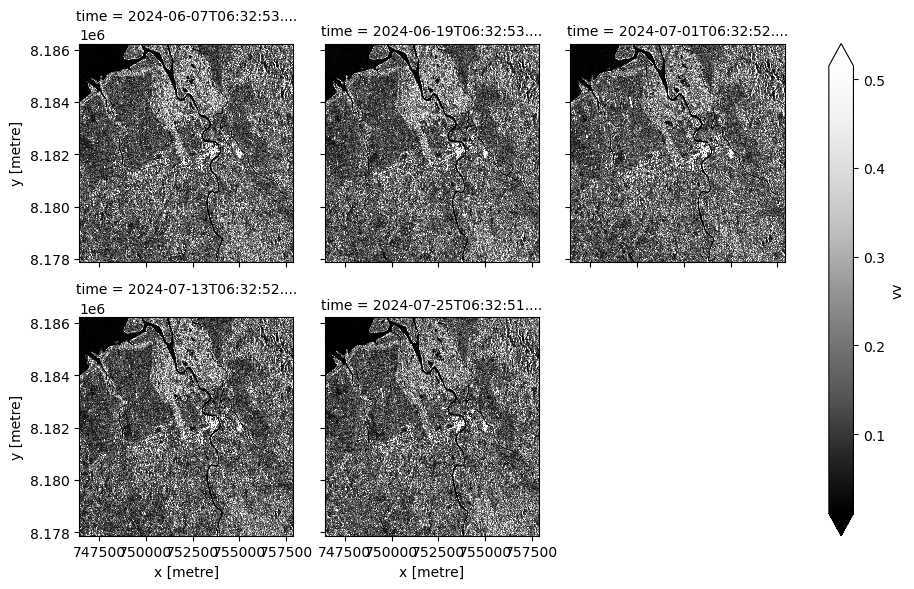

In [20]:
# Plot VV polarisation
data.isel(time=range(0,5)).vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3);

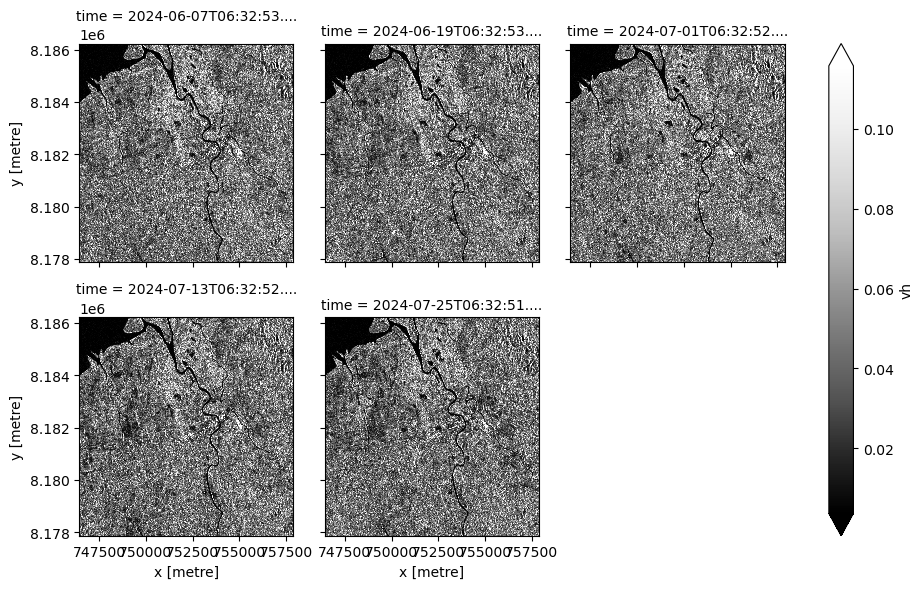

In [21]:
# Plot VH polarisation
data.isel(time=range(0,5)).vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3);

Backscatter measurements can be combined in visualization to highlight the different polarization signatures. 
For the RGB visualization below, the ratio between VH and VV is added as a third measurement band.

In [22]:
# VH/VV is a potentially useful third feature after VV and VH 
data['vh/vv'] = data.vh/data.vv

# Median values are used to scale the measurements so they have a similar range for visualization
medians = data.median(dim=["time"])

# Get scaled values so we can plot an RGB image for selected timesteps
scaled = data / medians

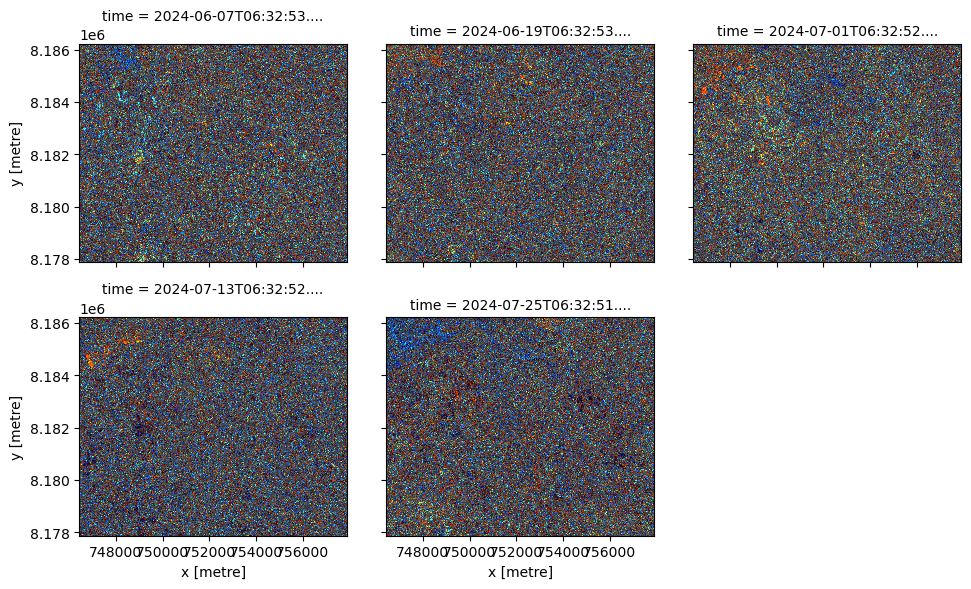

In [24]:
# Do the plotting
scaled.isel(time=range(0,5)).to_array().plot.imshow(robust=True, col="time", col_wrap=3);

## Apply speckle filtering

Radar observations appear speckly due to random interference of coherent signals from target scatters. 
The speckle noise can be reduced by averaging pixel values over an area or over time. 
However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution.
An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we apply the Lee filter, one of the popular adaptive speckle filters.


In [25]:
# Define a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    da_notime = da.squeeze()
    img = da_notime.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray, flipping the Y axis
    output = xr.DataArray(img_output, dims=da_notime.dims, coords=da_notime.coords)
    
    return output

# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = np.isfinite(data)
masked = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=7)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=7)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv)
data['filtered_vh'] = data.filtered_vh.where(valid.vh)

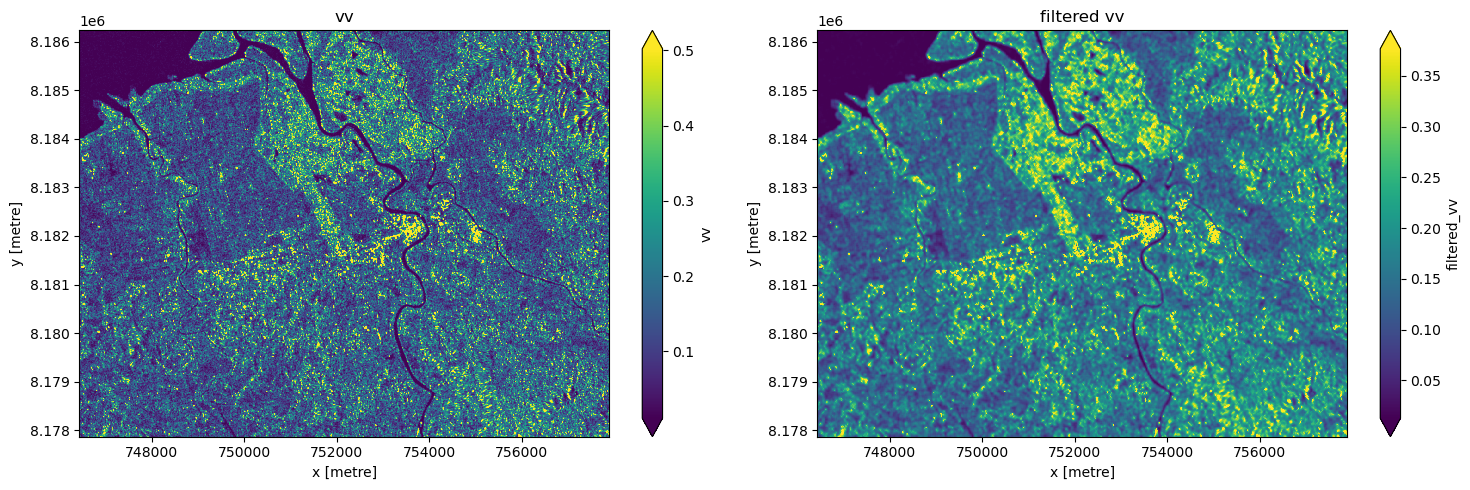

In [26]:
# Images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
data["vv"].isel(time=3).plot(ax = ax[0],robust=True)
data["filtered_vv"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('vv')
ax[1].set_title('filtered vv')
plt.tight_layout();

### Convert the digital numbers to dB

While Sentinel-1 backscatter is provided as linear intensity, it is often useful to convert the backscatter to decible (dB) for analysis. 
Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [27]:
data['filtered_vv'] = 10 * np.log10(data.filtered_vv)
data['filtered_vh'] = 10 * np.log10(data.filtered_vh)

## Histogram analysis for Sentinel-1

Backscatter distributions are plotted below as histograms.

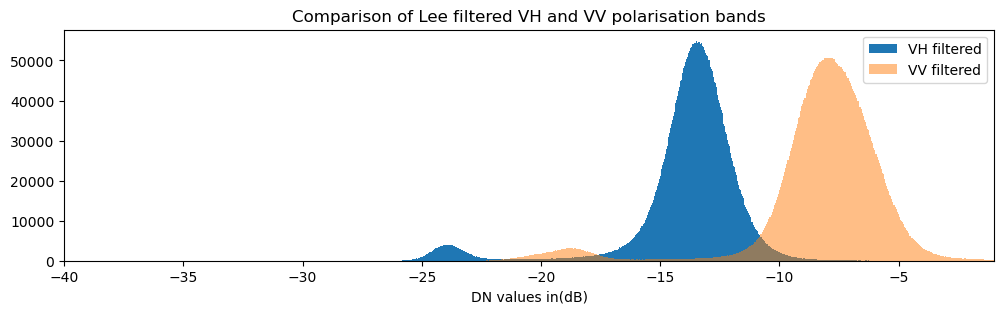

In [28]:
fig = plt.figure(figsize=(12, 3))
data.filtered_vh.plot.hist(bins=1000, label="VH filtered")
data.filtered_vv.plot.hist(bins=1000, label="VV filtered",alpha=0.5)
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

## Build and apply the classifier 

The histogram for VH backscatter shows a bimodal distribution with low values over water and high values over land.
The VV histogram has multiple peaks and less obvious seperation between water and land.

We therefore build a classifier based on VH backscatter. We choose a threshold to separate land and water: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are several ways to determine the threshold. 
Here, we use the `threshod_minimum` function implemented in the `skimage` package to determine the threshold from the *VH* histogram automatically.
This method computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold.

In [29]:
vv_no_nans = data.filtered_vv.values[~np.isnan(data.filtered_vv.values)]
threshold_vv = threshold_minimum(vv_no_nans)

print(threshold_vv)

-15.458185


### Visualise threshold

To check if our chosen threshold reasonably divides the two distributions, we can add the threshold to the histogram plots we made earlier. 

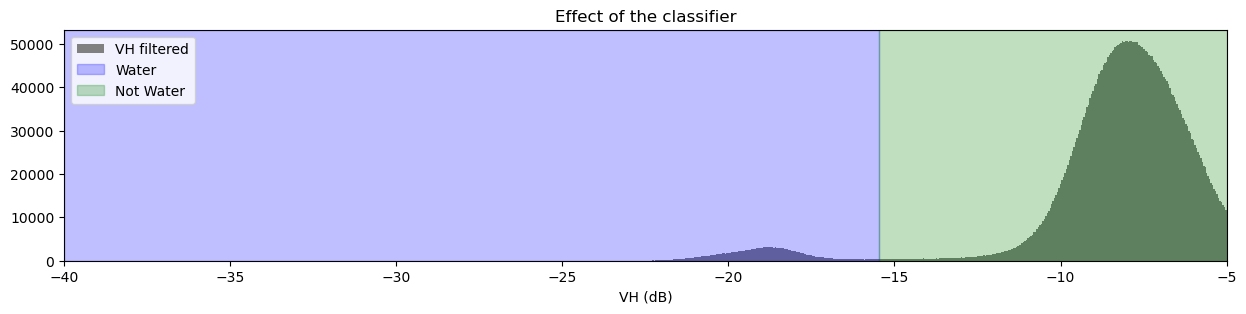

In [30]:
fig, ax = plt.subplots(figsize=(15, 3))
data.filtered_vv.plot.hist(bins=1000, label="VH filtered", color="gray")
plt.xlim(-40,-5)
ax.axvspan(xmin=-40.0, xmax=threshold_vv, alpha=0.25, color="blue", label="Water")
ax.axvspan(xmin=threshold_vv,
           xmax=-5,
           alpha=0.25,
           color="green",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

### Define the classifier

This threshold is used to write a function to only return the pixels that are classified as water. The basic steps that the function will perform are:

1. Find all pixels that have filtered values lower than the threshold; these are the `water` pixels.
2. Return a data set containing the `water` pixels.


In [35]:
def S1_water_classifier(da, threshold=threshold_vv):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

Now that we have defined the classifier function, we can apply it to the data. After running the classifier, we will able to view the classified data product by running `print(S1.water)`.

In [36]:
data['water'] = S1_water_classifier(data.filtered_vv).s1_water

### Assessment with mean

We can now view the image with our classification.
The classifier returns either `True` or `False` for each pixel.
To detect the boundaries of water features, we want to check which pixels are always water and which are always land.
Conveniently, Python encodes `True = 1` and `False = 0`.

If we plot the average classified pixel value, pixels that are always water will have an average value of `1` and pixels that are always land will have an average of `0`.
Pixels that are sometimes water and sometimes land will have an average between these values. In this case study, these pixels are associated with seasonally inundated wetland areas. 

The following cell plots the average classified pixel value, or the frequency of water detection, over time.

In [37]:
# Plot the mean of each classified pixel value
water_summary = (data.water.mean(dim='time') * 100).to_dataset(name="water_percentage")
water_summary["water_stdev"] = data.water.std(dim='time') * 100

water_summary.water_percentage.odc.explore(
    cmap="RdBu",
    vmin=0, 
    max=100,
    name="Water percentage",
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI WorldImagery",
)

You can see that the selected threshold has done a good job of separating the water pixels (in blue) and land pixels (in red) as well as ephemeral water features in between. 

You should be able to see that the shoreline takes on a mix of values between `0` and `1`, highlighting pixels that are sometimes land and sometimes water.
This is likely due to the effect of rising and falling tides, with some radar observations being captured at low tide, and others at high tide.



In [38]:
water_summary.water_stdev.odc.explore(
    tiles=basemaps.Esri.WorldImagery,
)